In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from collections import Counter

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import json

In [9]:
import base64
import os
from typing import Union

import cv2
import numpy as np

from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv
from openai import OpenAI
import json

load_dotenv()

endpoint = os.getenv("AZURE_LAYOUT_ENDPOINT")
key = os.getenv("AZURE_API_KEY")


document_intelligence_client = DocumentIntelligenceClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key),
)


In [10]:
def detect_figure_by_azure(img):
    """
    Azure Form Recognizerを使用して画像を処理し、結果をJSON形式で返す関数。

    Args:
        img (np.ndarray): 画像

    Returns:
        dict: 断面図の辞書
    """
    # np.ndarrayをバイト列に変換
    _, img_encoded = cv2.imencode('.png', img)
    img_bytes = img_encoded.tobytes()
    poller = document_intelligence_client.begin_analyze_document(
        "prebuilt-layout", analyze_request=img_bytes, content_type="application/octet-stream"
    )
    result = poller.result()

    # AnalyzeResult を辞書形式に変換してJSONで返す
    result_dict = result.as_dict()
    return result_dict

In [11]:
img = cv2.imread('_input/fukuoka_factory.png')
result_dict = detect_figure_by_azure(img)


In [12]:
def detect_figure_from_azure(result, img):
    cropped_regions = {}

    if "figures" in result and result["figures"]:
        for figures_idx, figure in enumerate(result["figures"]):
            for region in figure.get("boundingRegions", []):
                polygon = region.get("polygon", [])
                if not polygon:
                    print(f"No polygon data in region: {region}")
                    continue

                # 座標を (x, y) のペアに変換
                points = [(int(polygon[i]), int(polygon[i + 1])) for i in range(0, len(polygon), 2)]
                
                # Get bounding box from points
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]
                x1, x2 = min(x_coords), max(x_coords)
                y1, y2 = min(y_coords), max(y_coords)

                # Crop the region and store it
                cropped_regions[f"figure_{figures_idx}"] = {
                    'x1': x1,
                    'y1': y1,
                    'x2': x2,
                    'y2': y2,
                    'image': img[y1:y2, x1:x2].copy()
                }

    return cropped_regions

In [13]:
cropped_regions = detect_figure_from_azure(result_dict, img)

In [14]:
from PIL import Image
Image.fromarray(cropped_regions['figure_0']['image'])


In [17]:
len(result_dict['figures'])

1

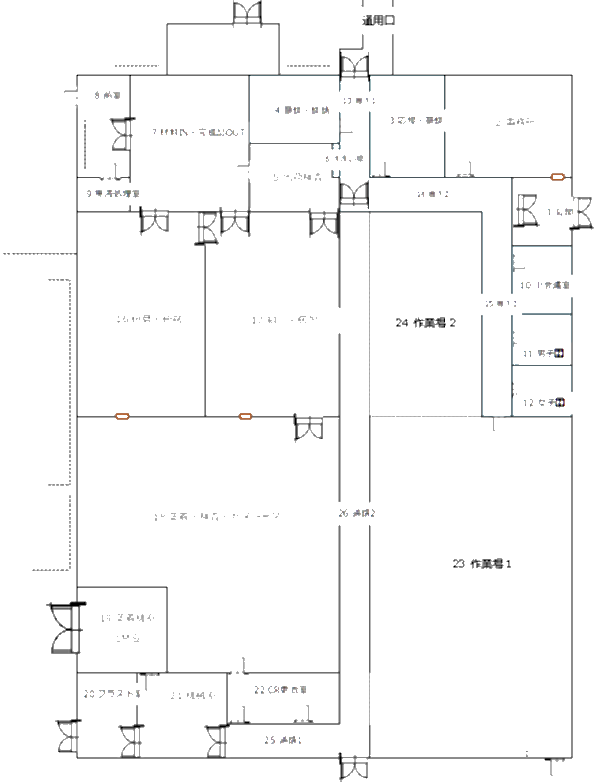

In [94]:
# 黒色の範囲を定義（BGR形式）
lower_black = np.array([0, 0, 0])
upper_black = np.array([190, 190, 190])  # より厳密な範囲に調整

fukuoka_img = cv2.imread('_input/fukuoka_factory_cropped.png')
# 黒色の範囲内のピクセルのマスクを作成
mask = cv2.inRange(fukuoka_img, lower_black, upper_black)

# 白い背景を作成
white_background = np.full(fukuoka_img.shape, 255, dtype=np.uint8)

# マスクを反転（黒い部分を白に、白い部分を黒に）
mask_inv = cv2.bitwise_not(mask)

# 背景（白）と黒いピクセルを組み合わせる
result = cv2.bitwise_and(white_background, white_background, mask=mask_inv)
black_pixels = cv2.bitwise_and(fukuoka_img, fukuoka_img, mask=mask)
final_result = cv2.add(result, black_pixels)
Image.fromarray(final_result)


In [95]:
import cv2
import time
from pylsd.lsd import lsd

import numpy as np

img = cv2.imread('_input/fukuoka_factory_cropped.png')
# img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(5,5),5)


linesL = lsd(gray)
t3 = time.time()


img3 = img.copy()
img4 = img.copy()
for line in linesL:
    x1, y1, x2, y2 = map(int,line[:4])
    img3 = cv2.line(img3, (x1,y1), (x2,y2), (0,0,255), 2)
    if (x2-x1)**2 + (y2-y1)**2 > 1500:
       # 赤線を引く
       img4 = cv2.line(img4, (x1,y1), (x2,y2), (0,0,255), 2)

print("LSD")
print(len(linesL),"lines")
cv2.imwrite('samp_pylsd.jpg',img3)
cv2.imwrite('samp_pylsd2.jpg',img4)


LSD
411 lines


True

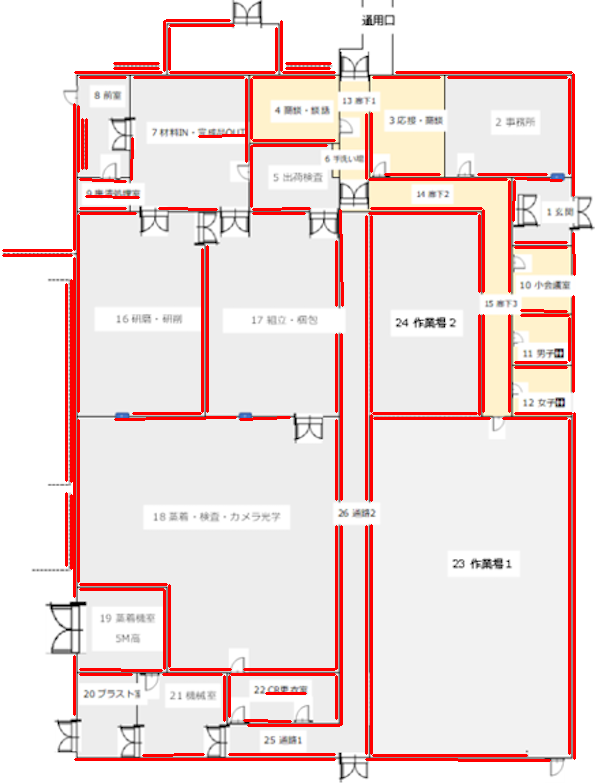

In [96]:
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
Image.fromarray(img4)

In [31]:
kaizuka_img = cv2.imread('_input/kaizuka_cropped.png')


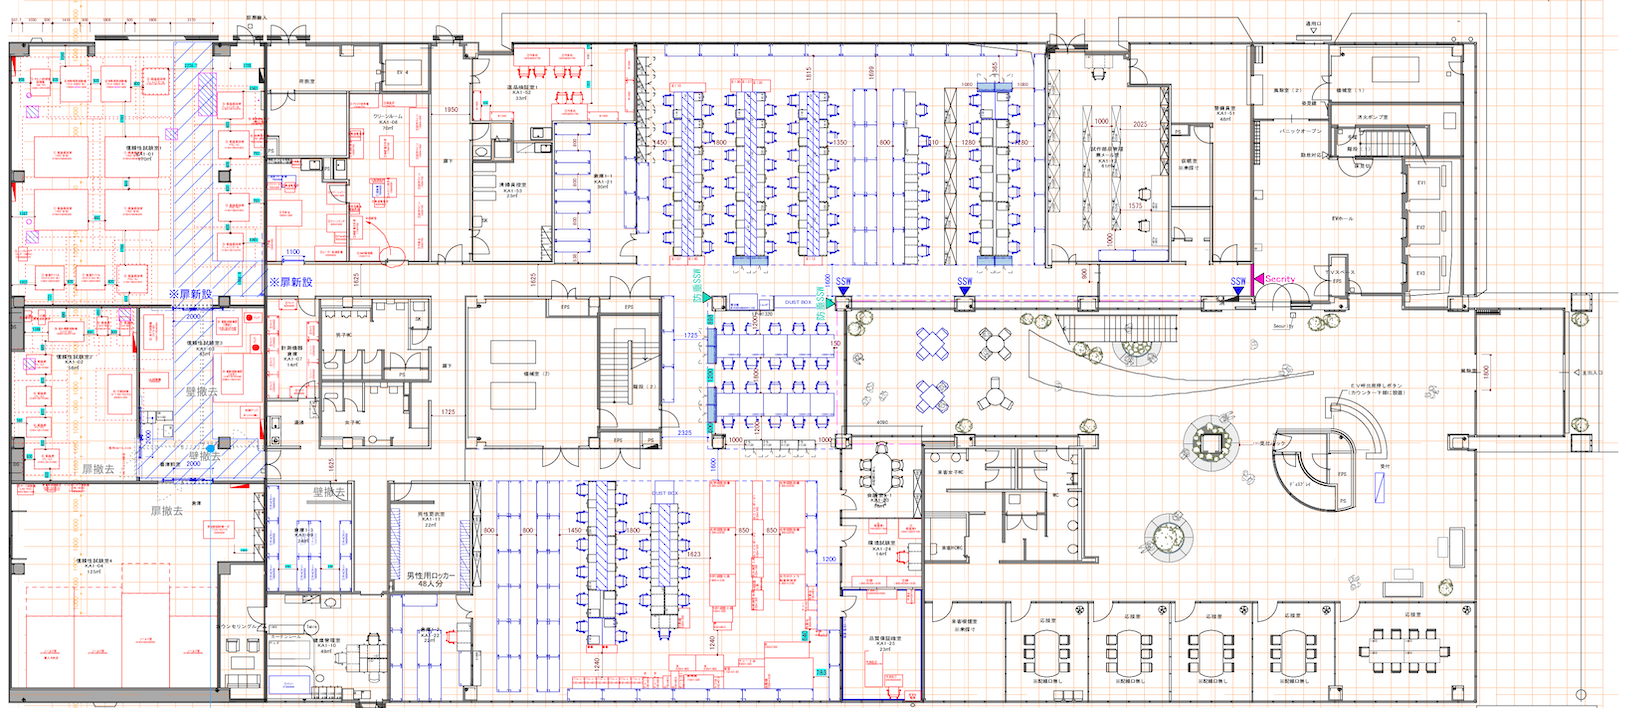

In [33]:
Image.fromarray(kaizuka_img)

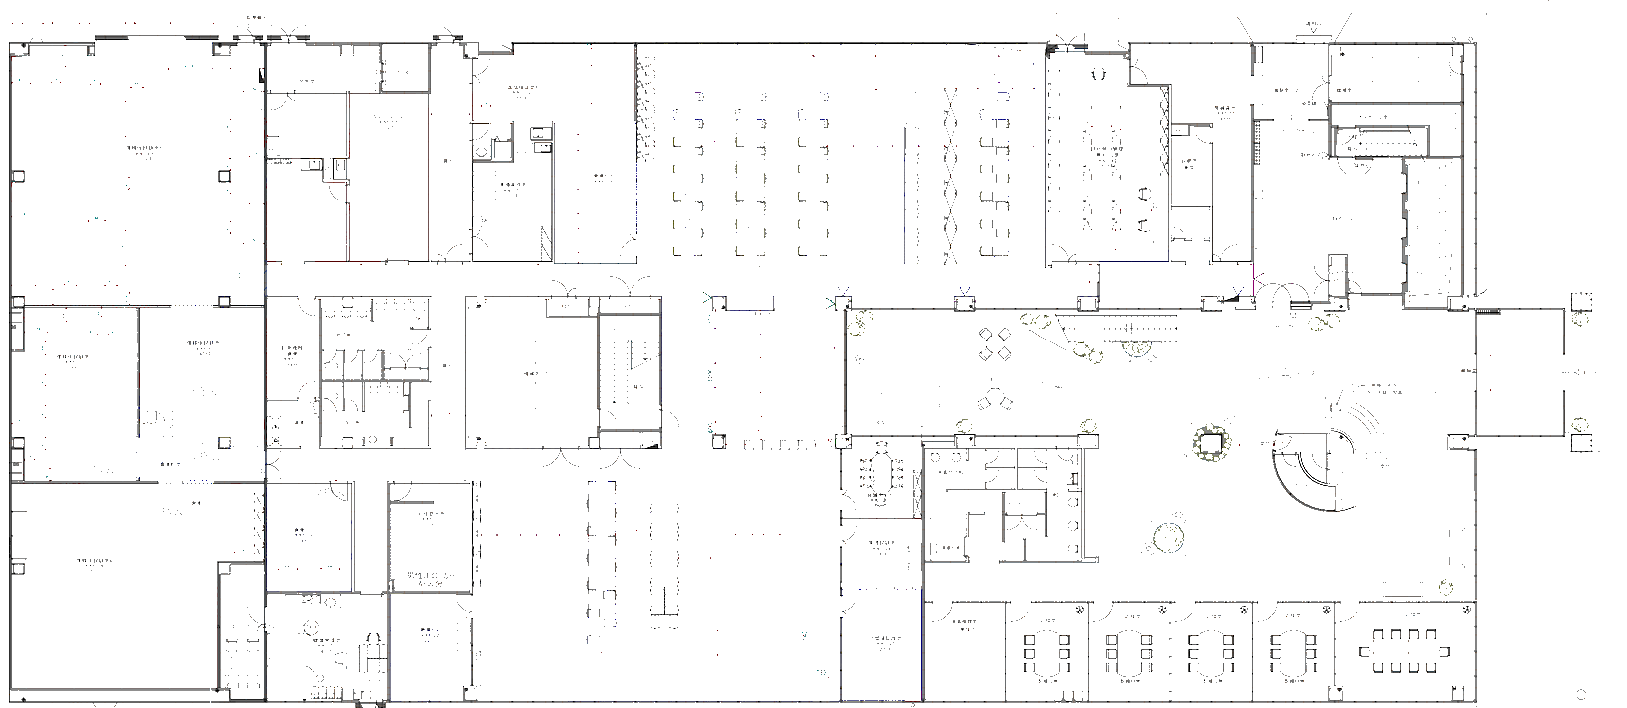

In [62]:
# 黒色の範囲を定義（BGR形式）
lower_black = np.array([0, 0, 0])
upper_black = np.array([150, 150, 150])  # より厳密な範囲に調整

# 黒色の範囲内のピクセルのマスクを作成
mask = cv2.inRange(kaizuka_img, lower_black, upper_black)

# 白い背景を作成
white_background = np.full(kaizuka_img.shape, 255, dtype=np.uint8)

# マスクを反転（黒い部分を白に、白い部分を黒に）
mask_inv = cv2.bitwise_not(mask)

# 背景（白）と黒いピクセルを組み合わせる
result = cv2.bitwise_and(white_background, white_background, mask=mask_inv)
black_pixels = cv2.bitwise_and(kaizuka_img, kaizuka_img, mask=mask)
final_result = cv2.add(result, black_pixels)
Image.fromarray(final_result)


In [63]:
cv2.imwrite('kaizuka_cropped_black.png', final_result)

True

LSD
397 lines


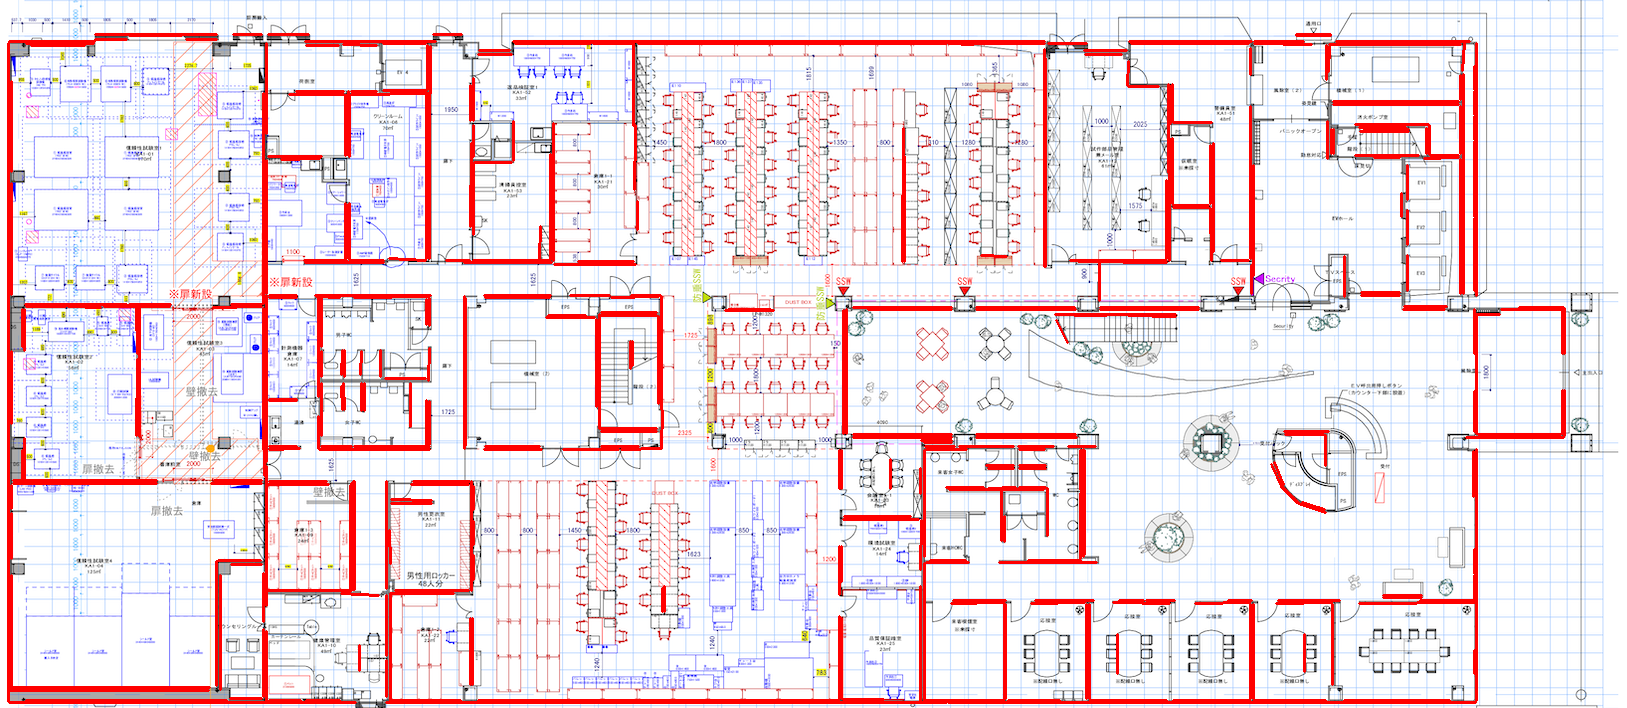

In [67]:
import cv2
import time
from pylsd.lsd import lsd

import numpy as np

img = final_result
original_img = kaizuka_img
# img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray,(5,5),5)


linesL = lsd(gray)
t3 = time.time()


img3 = original_img.copy()
img4 = original_img.copy()
num_lines = 0
for line in linesL:
    x1, y1, x2, y2 = map(int,line[:4])
    img3 = cv2.line(img3, (x1,y1), (x2,y2), (0,0,255), 3)
    if (x2-x1)**2 + (y2-y1)**2 > 500:
       num_lines += 1
       # 赤線を引く
       img4 = cv2.line(img4, (x1,y1), (x2,y2), (0,0,255), 2)

print("LSD")
print(num_lines,"lines")
cv2.imwrite('kaizuka_lsd.jpg',img3)
cv2.imwrite('kaizuka_lsd2.jpg',img4)

img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
Image.fromarray(img4)

In [86]:
pips_img = cv2.imread('_input/pips_e6f.png')
# Image.fromarray(pips_img)

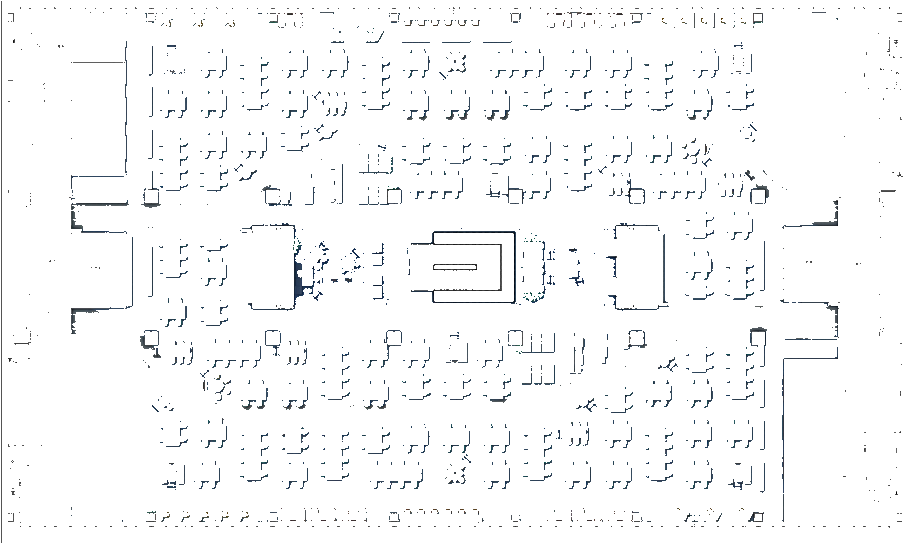

In [87]:
# 黒色の範囲を定義（BGR形式）
lower_black = np.array([0, 0, 0])
upper_black = np.array([100, 100, 100])  # より厳密な範囲に調整

# 黒色の範囲内のピクセルのマスクを作成
mask = cv2.inRange(pips_img, lower_black, upper_black)

# 白い背景を作成
white_background = np.full(pips_img.shape, 255, dtype=np.uint8)

# マスクを反転（黒い部分を白に、白い部分を黒に）
mask_inv = cv2.bitwise_not(mask)

# 背景（白）と黒いピクセルを組み合わせる
result = cv2.bitwise_and(white_background, white_background, mask=mask_inv)
black_pixels = cv2.bitwise_and(pips_img, pips_img, mask=mask)
final_result = cv2.add(result, black_pixels)
Image.fromarray(final_result)


LSD
449 lines


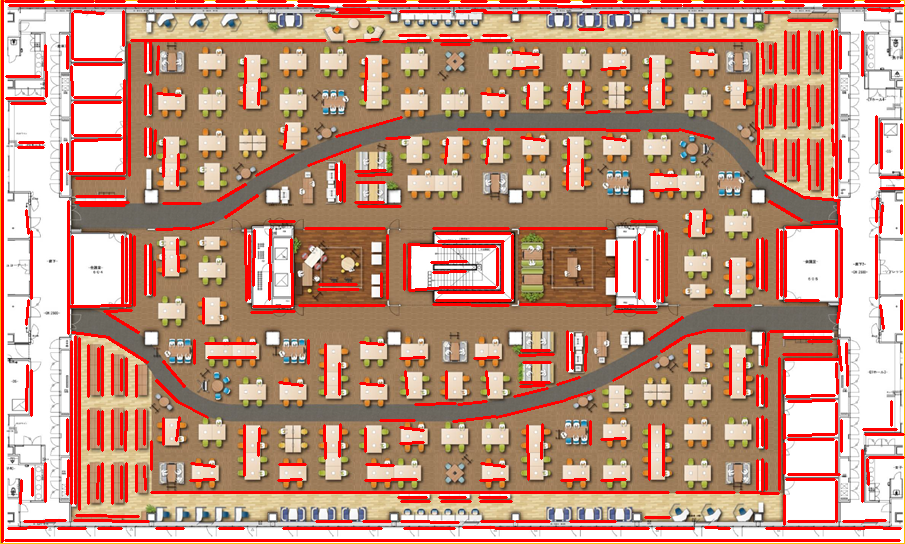

In [89]:
import cv2
import time
from pylsd.lsd import lsd

import numpy as np

img = pips_img
original_img = pips_img
# img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(5,5),5)


linesL = lsd(gray)
t3 = time.time()


img3 = original_img.copy()
img4 = original_img.copy()
num_lines = 0
for line in linesL:
    x1, y1, x2, y2 = map(int,line[:4])
    img3 = cv2.line(img3, (x1,y1), (x2,y2), (0,0,255), 3)
    if (x2-x1)**2 + (y2-y1)**2 > 500:
       num_lines += 1
       # 赤線を引く
       img4 = cv2.line(img4, (x1,y1), (x2,y2), (0,0,255), 2)

print("LSD")
print(num_lines,"lines")
cv2.imwrite('pips_lsd.jpg',img3)
cv2.imwrite('pips_lsd2.jpg',img4)

img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
Image.fromarray(img4)


LSD
119 lines


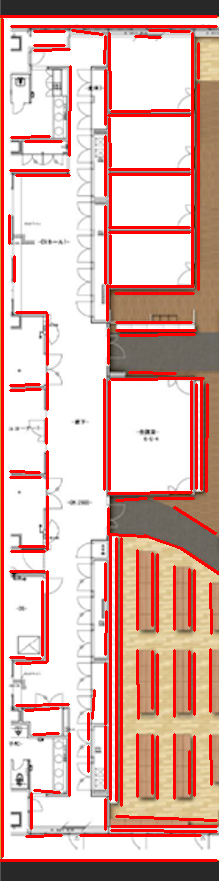

In [85]:
pips_img = cv2.imread('_input/pips_cropped.png')

# 黒色の範囲を定義（BGR形式）
lower_black = np.array([0, 0, 0])
upper_black = np.array([200, 200, 200])  # より厳密な範囲に調整

# 黒色の範囲内のピクセルのマスクを作成
mask = cv2.inRange(pips_img, lower_black, upper_black)

# 白い背景を作成
white_background = np.full(pips_img.shape, 255, dtype=np.uint8)

# マスクを反転（黒い部分を白に、白い部分を黒に）
mask_inv = cv2.bitwise_not(mask)

# 背景（白）と黒いピクセルを組み合わせる
result = cv2.bitwise_and(white_background, white_background, mask=mask_inv)
black_pixels = cv2.bitwise_and(pips_img, pips_img, mask=mask)
final_result = cv2.add(result, black_pixels)

img = final_result
original_img = pips_img
# img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(5,5),5)


linesL = lsd(gray)
t3 = time.time()


img3 = original_img.copy()
img4 = original_img.copy()
num_lines = 0
for line in linesL:
    x1, y1, x2, y2 = map(int,line[:4])
    img3 = cv2.line(img3, (x1,y1), (x2,y2), (0,0,255), 3)
    if (x2-x1)**2 + (y2-y1)**2 > 600:
       num_lines += 1
       # 赤線を引く
       img4 = cv2.line(img4, (x1,y1), (x2,y2), (0,0,255), 2)

print("LSD")
print(num_lines,"lines")
cv2.imwrite('pips_cropped_lsd.jpg',img3)
cv2.imwrite('pips_cropped_lsd2.jpg',img4)

img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
Image.fromarray(img4)


